# Análise de Série Temporal de PASSO_REAL
Este notebook apresenta a separação do código original em seções documentadas para facilitar a leitura e manutenção.

## Resolvendo problema com dependências

In [5]:
# (re)instala numpy na versão compatível
%pip install numpy==1.26.4

# depois instala/reinstala as outras dependências
%pip install pandas~=2.2.3 \ seaborn~=0.13.2 \ matplotlib~=3.10.1 \ statsmodels~=0.14.4 \ pmdarima~=2.0.4

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   -- ------------------------------------- 0.8/15.5 MB 6.7 MB/s eta 0:00:03
   -------------------- ------------------- 8.1/15.5 MB 29.7 MB/s eta 0:00:01
   ----------------------------------- ---- 13.6/15.5 MB 30.6 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.2 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.0 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 1. Imports e Leitura de Dados

In [1]:
# =======================
# 1. Imports e Configurações
# =======================
import pmdarima as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Carregar o dataset
df_raw = pd.read_excel("PASSO_REAL.xlsx")

## 2. Pré-processamento

In [5]:
df_raw.head()

,ANO,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ
0,1931,96,30,53,49,239,271,291,153,133,86,97,77
1,1932,60,78,77,398,292,189,294,270,345,234,112,97
2,1933,58,77,86,43,65,104,86,141,176,171,45,21
3,1934,32,211,101,141,233,288,196,178,231,180,100,87
4,1935,62,58,60,58,54,183,340,317,345,480,167,277


In [2]:
def modify_dataframe(dataframe):
    dataframe = dataframe.melt(id_vars='ANO', var_name='MONTH', value_name='VALUE')
    month_map = {
        'JAN': '01', 'FEV': '02', 'MAR': '03', 'ABR': '04',
        'MAI': '05', 'JUN': '06', 'JUL': '07', 'AGO': '08',
        'SET': '09', 'OUT': '10', 'NOV': '11', 'DEZ': '12'
    }
    dataframe['MONTH'] = dataframe['MONTH'].map(month_map)
    dataframe['DATE'] = dataframe['ANO'].astype(str) + '-' + dataframe['MONTH']
    dataframe = dataframe[['DATE', 'VALUE']].sort_values(by='DATE').reset_index(drop=True)
    return dataframe

# Aplicar transformação
df = modify_dataframe(df_raw)

In [6]:
df.head()

,DATE,VALUE
0,1931-01,96
1,1931-02,30
2,1931-03,53
3,1931-04,49
4,1931-05,239


## 3. Visualização

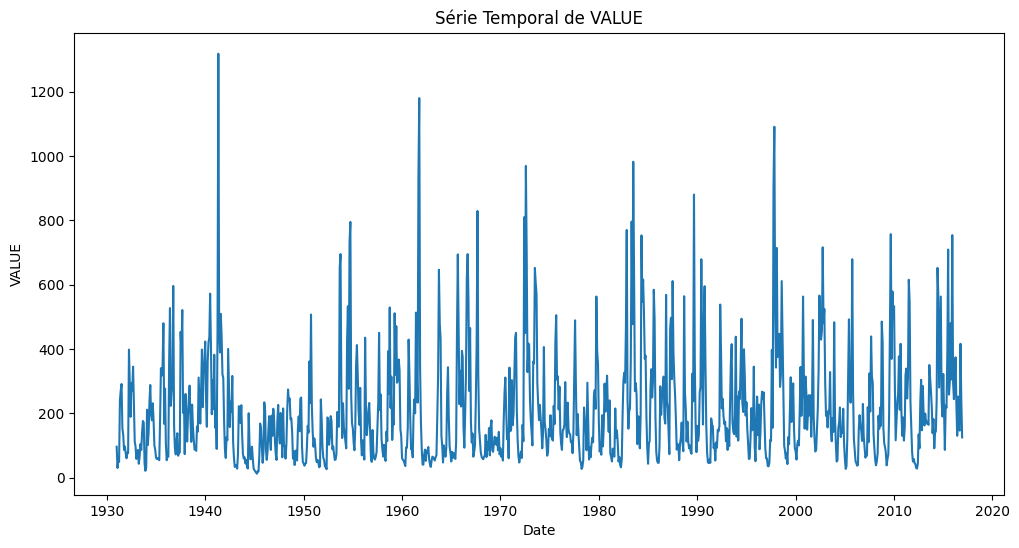

In [3]:
def plot_time_series(dataframe):
    dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
    dataframe.set_index('DATE', inplace=True)
    plt.figure(figsize=(12, 6))
    plt.plot(dataframe['VALUE'])
    plt.title('Série Temporal de VALUE')
    plt.ylabel('VALUE')
    plt.xlabel('Date')
    plt.show()

# Plotar série temporal
plot_time_series(df.copy())

### Boxplot por Ano e por Mês

C:\Users\msoli\AppData\Local\Temp\ipykernel_3076\3384275694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


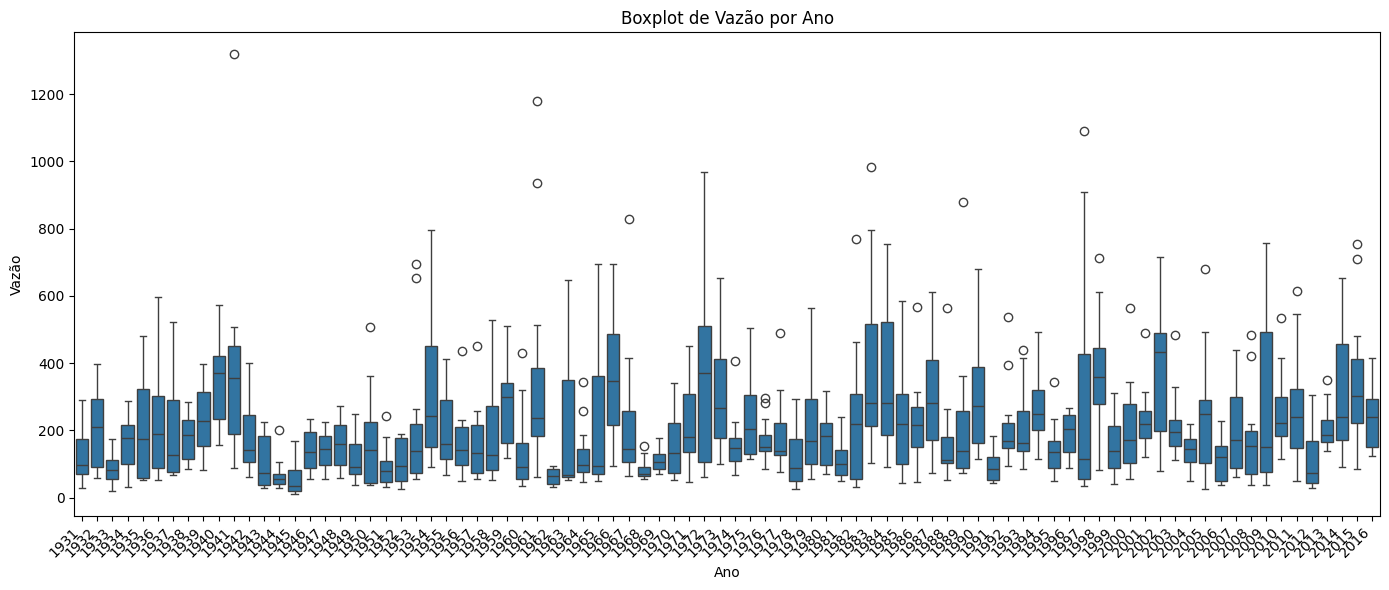

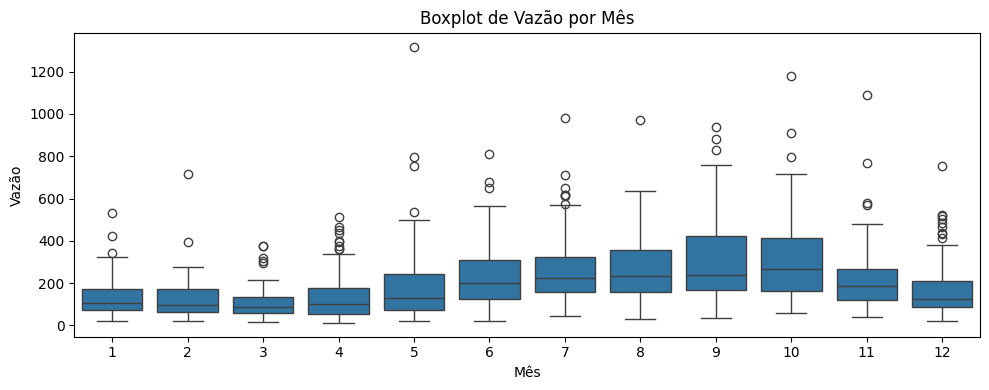

In [24]:
def year_month_boxplots(dataframe):
    # garante DatetimeIndex
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
        dataframe.set_index('DATE', inplace=True)

    dataframe['YEAR'] = dataframe.index.year
    dataframe['MONTH'] = dataframe.index.month

    # --- Boxplot por Ano ---
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(x='YEAR', y='VALUE', data=dataframe.reset_index(), ax=ax)
    ax.set_title('Boxplot de Vazão por Ano')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Vazão')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Boxplot por Mês ---
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x='MONTH', y='VALUE', data=dataframe.reset_index(), ax=ax)
    ax.set_title('Boxplot de Vazão por Mês')
    ax.set_xlabel('Mês')
    ax.set_ylabel('Vazão')
    # rótulos de mês permanecem horizontais
    plt.tight_layout()
    plt.show()

# Gerar boxplots
year_month_boxplots(df.copy())

## 4. Teste de Estacionaridade, Decomposição, Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

### 4.1. Teste de Estacionaridade

In [ ]:
# Teste de raiz unitária (Dickey–Fuller)
result = adfuller(df['VALUE'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.528973
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### 4.2. Decomposição Sazonal

Decomposição Multiplicativa


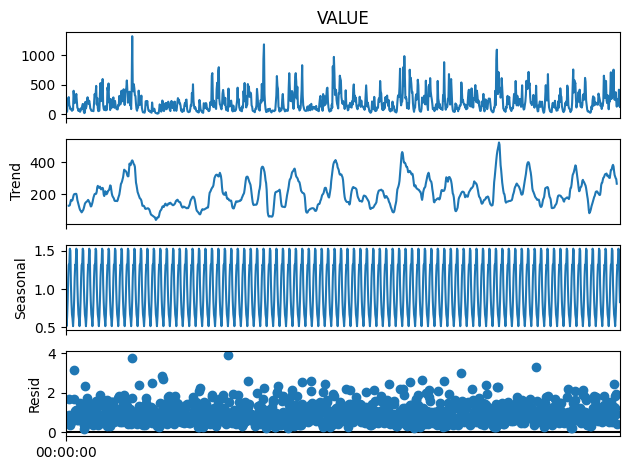

Decomposição Aditiva


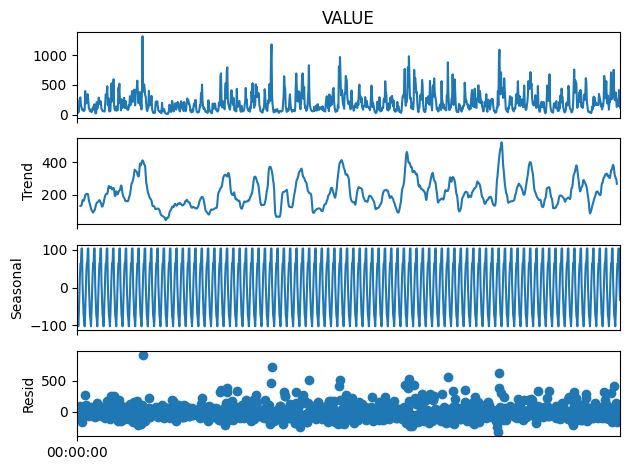

In [30]:
# Decomposição sazonal
print('Decomposição Multiplicativa')
df.index = pd.to_datetime(df.index)
decomp = seasonal_decompose(df['VALUE'], model='multiplicative', period=12)
decomp.plot()
plt.show()
print('Decomposição Aditiva')
decomp_add = seasonal_decompose(df['VALUE'], model='additive', period=12)
decomp_add.plot()
plt.show()

### 4.3. Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

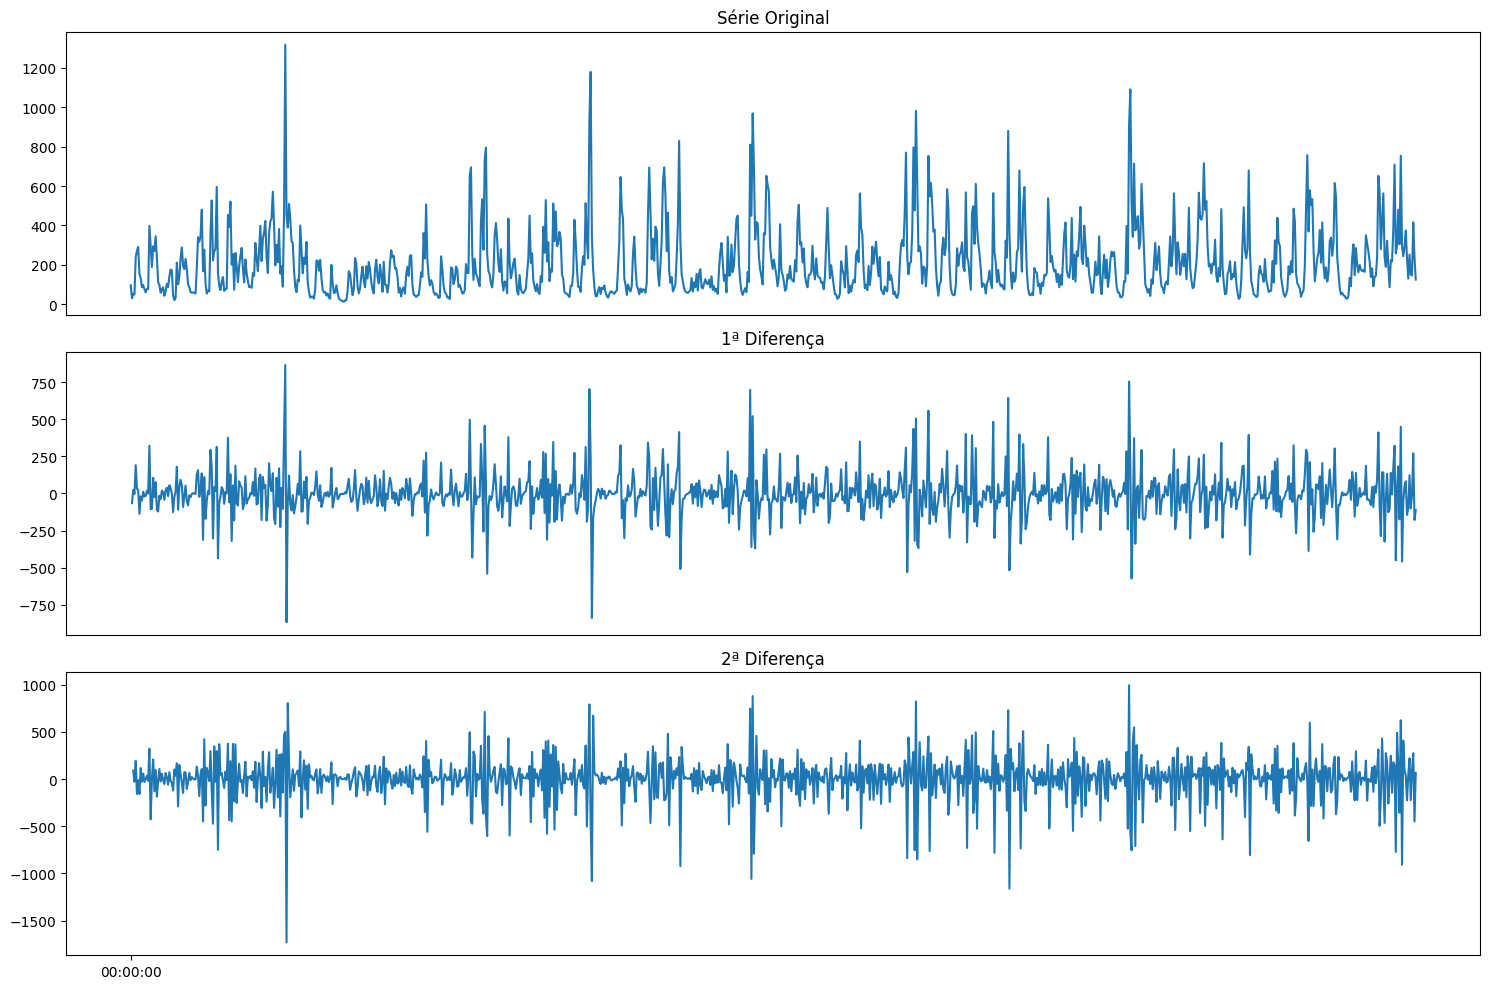

In [37]:
# --------------------------------------------------
# Plot de Diferenciações
# --------------------------------------------------
import matplotlib.pyplot as plt

# Gera figura com 3 plots empilhados
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 10))

# Série original
axes[0].plot(df['VALUE'])
axes[0].set_title('Série Original')
axes[0].axes.xaxis.set_visible(False)

# 1ª diferença
axes[1].plot(df['VALUE'].diff())
axes[1].set_title('1ª Diferença')
axes[1].axes.xaxis.set_visible(False)

# 2ª diferença
axes[2].plot(df['VALUE'].diff().diff())
axes[2].set_title('2ª Diferença')

plt.tight_layout()
plt.show()


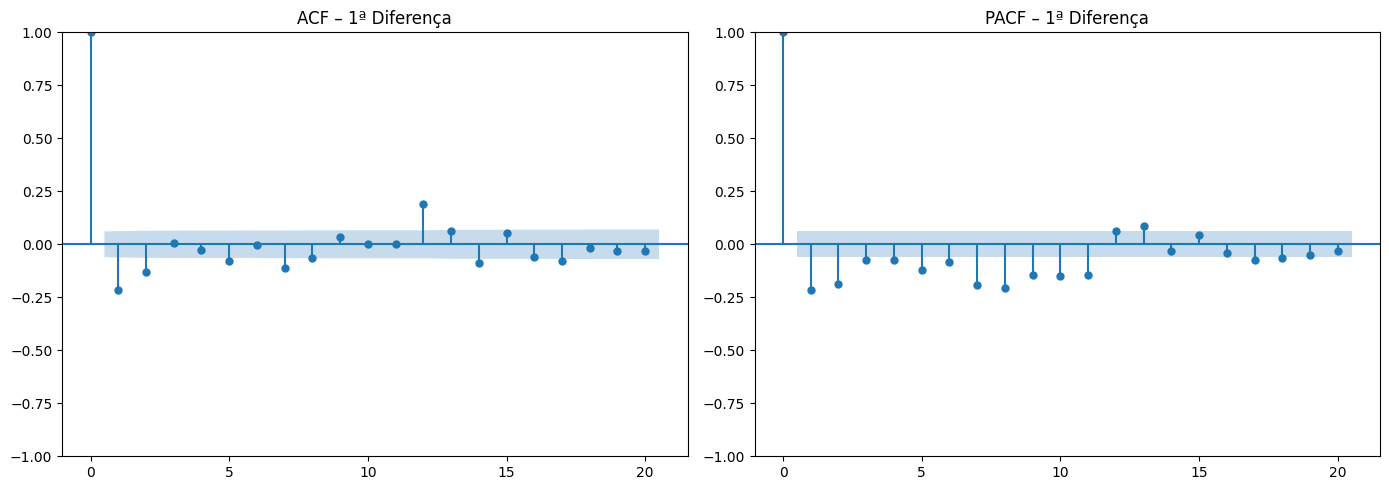

In [41]:
# --------------------------------------------------
# Autocorrelação (ACF) e Autocorrelação Parcial (PACF)
# --------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define série diferenciada para análise (1ª diferença)
ts_diff = df['VALUE'].diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(ts_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF – 1ª Diferença')

# PACF
plot_pacf(ts_diff, lags=20, ax=axes[1])
axes[1].set_title('PACF – 1ª Diferença')

plt.tight_layout()
plt.show()

## 5. Modelagem ARMA (p, q)

## 6. Modelagem ARIMA (p, d=1, q)

C:\Users\msoli\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
C:\Users\msoli\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
C:\Users\msoli\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                 1032
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6534.271
Date:                Sun, 27 Apr 2025   AIC                          13076.543
Time:                        16:26:45   BIC                          13096.296
Sample:                    01-01-1970   HQIC                         13084.039
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6055      0.034     17.770      0.000       0.539       0.672
ma.L1         -1.0213      0.046    -22.196      0.000      -1.112      -0.931
ma.L2          0.0216      0.039      0.547      0.5

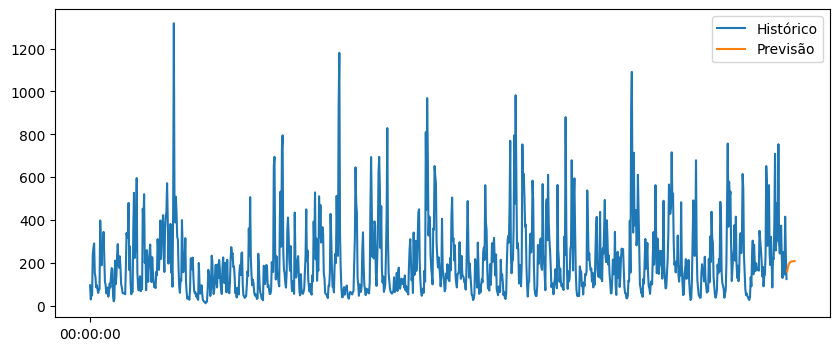

In [31]:
# Ajuste de modelo ARIMA
model = ARIMA(df['VALUE'], order=(1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

# Previsão
n_forecast = 12
forecast = model_fit.forecast(steps=n_forecast)
plt.figure(figsize=(10, 4))
plt.plot(df['VALUE'], label='Histórico')
plt.plot(forecast, label='Previsão')
plt.legend()
plt.show()

## 7. Modelagem SARIMA (p, d=1, q) (P, D=1, Q)m = 12 

## 8. Análise a Precisão dos Modelos com EPMA (Erro Percentual Médio Absoluto)

## 9. Análise de Erro de Persistência para Validação dos Modelos